## Modules

In [2]:
import os
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
 
from datetime import datetime, timedelta
from itertools import product
from scipy.stats import norm

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

## Log-normal returns simulation

### Normal random vectors of log return & percentage return

In [3]:
miu0 = 0.12
sig0 = 0.24
k0 = 20
randVect0 = np.random.normal(miu0, sig0, k0)

print(f'Random log returns of {k0} periods:\n {randVect0}, \n')
print(f'Random percentage returns of {k0} periods:\n {np.exp(randVect0) - 1}')

Random log returns of 20 periods:
 [ 0.31149252  0.08840296 -0.07458936 -0.31802786  0.55233412  0.21727252
  0.70650137  0.08226892 -0.01220037 -0.36745015 -0.02214382  0.52062538
  0.56816429 -0.20467454  0.33017716 -0.13804713 -0.04719828  0.22233502
  0.33009827 -0.06470613], 

Random percentage returns of 20 periods:
 [ 0.36546157  0.09242824 -0.07187547 -0.27241748  0.73730336  0.24268271
  1.02688751  0.08574775 -0.01212625 -0.30750215 -0.02190045  0.68307989
  0.765024   -0.18508751  0.39121458 -0.12894236 -0.04610176  0.24898974
  0.39110483 -0.06265712]


### Fixed-leverage-betting on normally distributed returns

In [4]:
def getSim_fixLev(initAmount=100, lev=1.00, miu=0.05, sig=0.2, numPeriod=60, numSim=1000):
    """
    Obtain dataframe of fixed-leverage-bet simulations, with returns of each interval normally distributed.
    Assume zero-cost-rebalance at the end of each period.
    initAmount: initial capital
    miu: (non-annualized) mean return
    sig: (non-annualized) sigma
    numPeriod: number of periods
    numSim: number of simulations
    """
    # Dict for recording different series of total equity
    amountDict = {}
    # Generate a total of `numSim`= N series of normally distributed returns
    for num in range(numSim):
        # vector of log returns in each period and exponentiate
        pctArray = np.exp(np.random.normal(miu, sig, numPeriod))
        # convert into growth factor vector by converting to percentage change vector, multiply by leverage, and add 1
        factorArray = 1 + lev * (pctArray - 1)
        # equity vector by cumulative multiplying by growth factors
        amountArray = initAmount * factorArray.cumprod()
        # IF equity drops to 0 or even below (due to over-leverage), stop betting, set the remaining equity to 1/10000
        # of initial amount and fix it in the remaining series (for the sake of legal semi-log equity curve plotting)
        # (This artificial "residual equity" is unreal assummption, the reality is more cruel than this!)
        period = 1
        ruimAmount = initAmount / 10000
        while period <= numPeriod - 1:
            if amountArray[period] <= ruimAmount:
                for j in range(period, numPeriod):
                    amountArray[j] = ruimAmount
                break
            period += 1
        amountDict[f's{num + 1}'] = amountArray
        # Form dataframe from the `amountDict` and transpose, so that each row corresponds to a betting series
    dfSim = pd.DataFrame(amountDict).transpose()
    # Rename columns so that each number in column labels corresponds to the k-th trial
    dfSim = dfSim.rename(columns={k: (k + 1) for k in dfSim.columns})

    return dfSim

### Sample of 20 simulations of 12 periods

In [5]:
initAmount1 = 100
lev1 = 2.00
miu1 = 0.04
sig1 = 0.16
numPeriod1 = 12
numSim1 = 20

dfSim1 = getSim_fixLev(initAmount1, lev1, miu1, sig1, numPeriod1, numSim1) 
np.round(dfSim1, 2)

1       2       3       4        5        6        7        8   \
s1   151.41  244.42  360.68  553.90   598.41   338.16   156.25   143.31   
s2    89.35  119.39  189.26  421.45   514.86   179.93   241.42   264.96   
s3    99.09   77.21   96.66  115.41    82.95    91.17    69.44    69.14   
s4    90.82  123.77   86.33   61.59   102.40   180.79   166.11   260.25   
s5   114.33  108.86  181.20  226.18   295.77   445.81   257.81   451.35   
s6   110.98   81.87   67.45   47.61    58.13    78.09    82.41    95.27   
s7   103.76   53.13   66.16   68.48    88.23    66.82    94.84    99.47   
s8    76.75   53.28   71.23   79.71   108.37    62.64    43.27    33.27   
s9    81.73   88.29   91.79   83.26   124.10   241.76   166.24   280.98   
s10   96.49  119.90   84.91   47.68    60.30    65.74    84.27   128.74   
s11   96.89   87.65  142.52  145.34   247.36   342.48   214.38   201.05   
s12   99.25  148.24  209.76  236.50   246.41   355.18   169.59    64.87   
s13  109.75   98.81   89.42   87.11   123.60   110.30   171.77   320.53   
s14   71.65   84.22   61.96   56.85    71.74    94.42    81.52    57.59   
s15  188.41  396.09  681.97  828.77  1215.09  1413.78  1054.15  1140.50   
s16   95.94   87.43   69.14   80.96    87.33    98.04   116.93   131.54   
s17   90.49  121.42  159.27  196.54   218.24   180.43   173.36   178.43   
s18  145.78  161.73  191.97  134.04   150.55   138.19    23.74    21.24   
s19  154.66  127.77  198.82  213.44   225.80   239.58   156.58   122.79   
s20   97.92   79.22  127.61  226.82   174.21   204.34   189.07   226.44   

          9        10       11      12  
s1    152.34   106.91   127.03  183.48  
s2    371.76   521.63   612.70  481.72  
s3    132.35   103.07    80.12  171.86  
s4    480.93   541.42   625.93  870.44  
s5    729.24   546.08   666.51  544.59  
s6     70.43    41.26    50.37   58.59  
s7    174.95   123.50    91.78  122.35  
s8     36.09    39.43    53.08   60.95  
s9    234.24   126.79   155.91  135.51  
s10   191.88   155.20   128.89   69.90  
s11   200.55   153.17   171.45  187.01  
s12    49.80    37.20    41.43   67.81  
s13   423.12   214.87   312.76  461.55  
s14    85.86   116.29   104.37  168.74  
s15  1241.99  1258.95  1203.33  452.46  
s16    82.82    82.39    96.07  115.11  
s17   199.24   182.78   221.39  265.16  
s18    17.73    18.03    21.71   31.68  
s19   141.92   197.65   172.57   70.33  
s20   216.97   456.61   226.85  261.50

## Equity curve plotting

### Simulation KPIs

In [6]:
def getSimKPI_fixLev(initAmount=100, lev=1.00, miu=0.05, sig=0.2, numPeriod=60, numSim=1000):
    """Obtain a dictionary of final performance KPI of simulations. """
    dfSim = getSim_fixLev(initAmount, lev, miu, sig, numPeriod, numSim)
    kpiDict = {}
    kpiDict['miu'] = miu
    kpiDict['sig'] = sig
    kpiDict['lev'] = lev
    kpiDict['NAsharpe'] = round(miu * (numPeriod ** 0.5) / sig, 4)
    kpiDict['win%'] = round(100 * dfSim[dfSim[numPeriod] >= initAmount].shape[0] / numSim, 2)
    kpiDict['avgAmount'] = round(dfSim[numPeriod].mean(), 2)
    kpiDict['midAmount'] = round(dfSim[numPeriod].median(), 2)
    kpiDict['stdAmount'] = round(dfSim[numPeriod].std(), 2)

    return dfSim, kpiDict

### Sample 1 (same parameter as above)

In [7]:
initAmount1 = 100
lev1 = 1.5
miu1 = 0.03
sig1 = 0.15
numPeriod1 = 36
numSim1 = 1000

dfSim1, dictKPI1 = getSimKPI_fixLev(initAmount1, lev1, miu1, sig1, numPeriod1, numSim1) 
dictKPI1

{'miu': 0.03,
 'sig': 0.15,
 'lev': 1.5,
 'NAsharpe': 1.2,
 'win%': 82.1,
 'avgAmount': 937.55,
 'midAmount': 367.13,
 'stdAmount': 1665.28}

### Function

In [7]:
def plotSim_fixLev(initAmount=100, lev=1.00, miu=0.05, sig=0.2, numPeriod=60, numSim=1000):
    """Plot equity curves from the betting simulations."""
    # Dataframe and KPI dict from `getSimKPI()` function
    dfSim, dictKPI = getSimKPI_fixLev(initAmount, lev, miu, sig, numPeriod, numSim)
    # First line of diagram title
    title = f'{numSim} simulations of {numPeriod}-periods \n'
    title += f'leverage {round(lev, 4)}, miu {round(100*miu, 2)}%, sig {round(100*sig, 2)}%\n'
    # Percentage of final equity above or equal to initial amount
    winrate = dictKPI['win%']
    amountAvg = dictKPI['amountAvg'] # Arithmetic mean of final equity
    amountMed = dictKPI['amountMed'] # Median of final equity
    amountStd = dictKPI['amountStd'] # SD of final equity
    # Attach key stats to title text
    sharpe = dictKPI['NAsharpe']
    title += f'NA-sharpe: {sharpe}, final winrate: {winrate}% \n'
    title += f'Final equity mean: {amountAvg}, median: {amountMed}, SD: {amountStd}'
    # Plot figure
    fig = plt.figure(figsize=(12, 9))
    # Append title
    fig.suptitle(title, fontsize=12)
    # Transpose the equity dataframe to plot
    dfplot = dfSim.transpose()
    # Adopt semi-log scale for fixed-percent-betting & linear scale for fixed-amount-betting
    plt.semilogy(dfplot)
    plt.plot(dfplot.index, np.repeat(initAmount, numPeriod), color='black', linewidth=3, linestyle='dashed')
    plt.show()

### Plotting simulations of sample 1

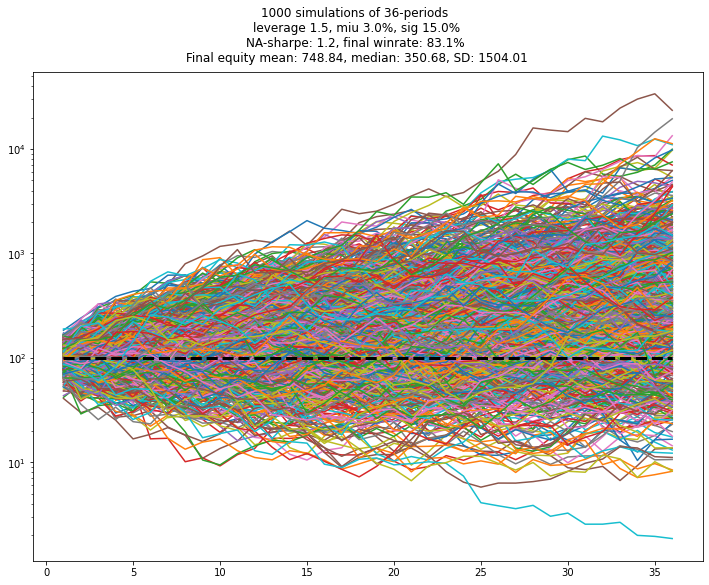

In [8]:
plotSim_fixLev(initAmount1, lev1, miu1, sig1, numPeriod1, numSim1)

### Reduce  `sig` with everything else unchanged

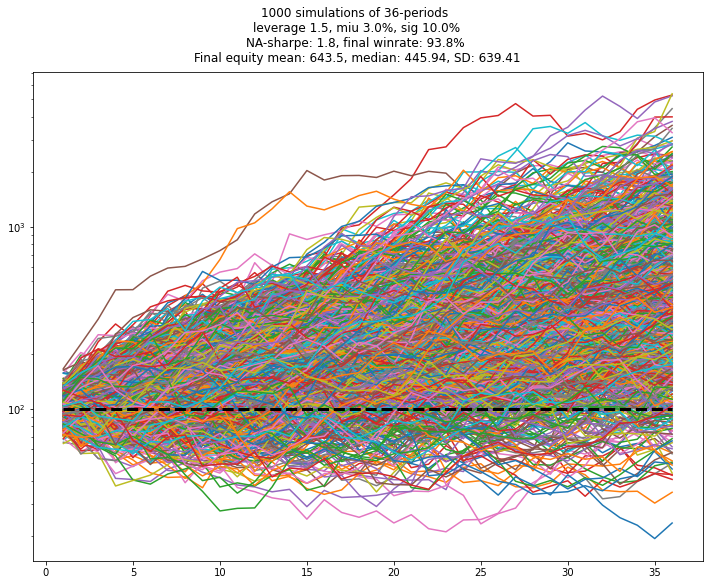

In [9]:
sig2 = 0.1
plotSim_fixLev(initAmount1, lev1, miu1, sig2, numPeriod1, numSim1)

### Raise both `miu` & `sig` but keeps NA-sharpe and leverage unchanged

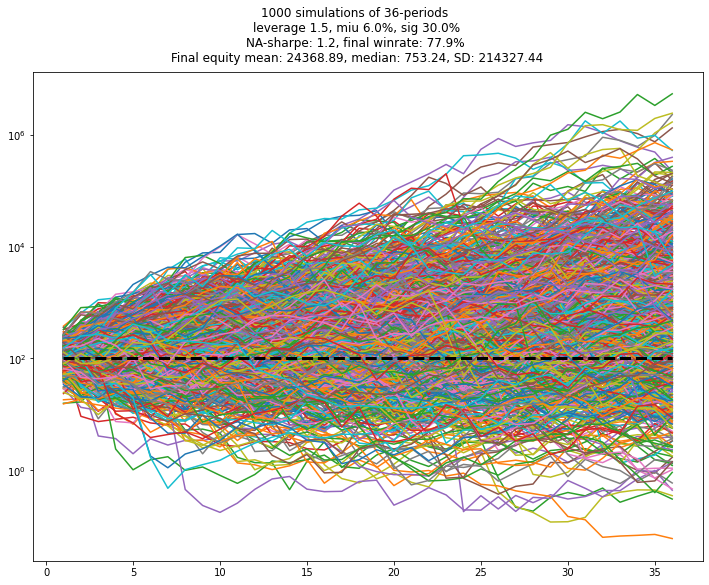

In [10]:
sharpe1 = 1.2 / (numPeriod1 ** 0.5)
miu3 = 0.06
sig3 = sig1 * miu3 / miu1

plotSim_fixLev(initAmount1, lev1, miu3, sig3, numPeriod1, numSim1)


### Function to check MDD

In [8]:
def getSimMDD(dfSim, levelsMDD=(0.2, 0.5, 0.8, 0.9)):
    """Obtain percentage of simulations with final amount dropping below the given equity threshold."""
    # Transpose the simulation dataframe
    dfSimT = dfSim.transpose()
    numTrials = dfSim.shape[1]
    numSim = dfSim.shape[0]
    # Compute MDD
    dfMDD = pd.DataFrame(columns=dfSimT.columns)
    for col in dfSimT.columns:
        dfMDD[col] = (dfSimT[col] / dfSimT[col].cummax() - 1).cummin()
    # Tranpose back to match original shape
    dfMDD = dfMDD.transpose()
    # Compute percentage of simulations having MDD greater than the levels
    dictMDD = {}
    for value in levelsMDD:
        dictMDD[value] = dfMDD[dfMDD[numTrials] <= -value].shape[0] / numSim

    return dfMDD, dictMDD

### Using example 1

In [12]:
dfMDD1, dictMDD1 = getSimMDD(dfSim1)
print(f'Percentage of betting series suffering \n')

for key, value in dictMDD1.items():
    print(f'{round(100*key)}% MDD: {round(100*value, 2)}%')

Percentage of betting series suffering 

20% MDD: 100.0%
50% MDD: 72.2%
80% MDD: 11.9%
90% MDD: 2.3%


### Using example 3

In [13]:
dfSim3, dictKPI3 = getSimKPI_fixLev(initAmount1, lev1, miu3, sig3, numPeriod1, numSim1) 

dfMDD3, dictMDD3 = getSimMDD(dfSim3)
print(f'Percentage of betting series suffering \n')

for key, value in dictMDD3.items():
    print(f'{round(100*key)}% MDD: {round(100*value, 2)}%')

Percentage of betting series suffering 

20% MDD: 100.0%
50% MDD: 98.3%
80% MDD: 67.3%
90% MDD: 40.5%


## Optimal leverage (Kelly formula of continuous returns)

### Expected geometric growth (for normally distributed returns)

- Reference: Edward Thorp, The Kelly Criterion in Blackjack, Sports Betting, and the Stock Market (1997)

In [14]:
def getNormalGrowth(lev=1.00, miu=0.03, sig=0.15, n=1):
    """Obtain expected geometric returns of random walk returns."""
    logGrowth = lev * (miu - sig ** 2 * lev / 2)

    return np.exp(n * logGrowth)

def plotNormalGrowth(miu=0.03, sig=0.15, n=1, levMin=0.20, levMax=4.0, step=0.001):
    """Plot expected geometric growth given miu & sigma, and identify optimal leverage."""
    # Form pandas Series of expected return of varying leverage
    arrLev = np.arange(levMin, levMax, step)
    dictGrowth = {lev: getNormalGrowth(lev, miu, sig, n) for lev in arrLev}
    dfGrowth = pd.DataFrame(pd.Series(dictGrowth))
    # Plot interactive diagram of f-percent curve
    fig = px.line(x=dfGrowth.index, y=dfGrowth[0], labels={'x': 'lev', 'y': f'growth factor on {n} periods'})
    fig.add_trace(go.Scatter(x=dfGrowth.index, y=np.repeat(0, len(arrLev)), name='0%'))
    # Identify optimal leverage
    bestLev = round(dfGrowth[0].idxmax(), 4)
    bestGrowth = round(dfGrowth[0].max(), 4)
    fig.add_trace(go.Scatter(x=(bestLev, ), y=(bestGrowth, ), line_color='green', name='Opt-lev', mode='markers+text',
                             marker_size=10, text=f'{bestLev, round(bestGrowth, 4)}', textposition='bottom center'))
    # Title
    fig.update_layout(title=f'Expected geometric growoth of N({miu}, {sig})', title_x=0.5, width=1000, height=500)
    # Show diagram
    fig.show()

### Example 1

In [15]:
getNormalGrowth(lev1, miu1, sig1, numPeriod1)

2.031450357967213

In [16]:
plotNormalGrowth(miu1, sig1, numPeriod1)

### Example 2

In [17]:
plotNormalGrowth(miu1, sig2, numPeriod1, 1.0, 5.0)

### Example 3

In [18]:
plotNormalGrowth(miu3, sig3, numPeriod1, 0.2, 2.0)

### Kelly optimal leverage (for normally distributed returns ONLY)

In [19]:
def getkellyLev(miu, sig):
    """Obtain Kelly formula of optimal leverage."""
    return round(max(miu / sig**2, 0), 4)

### Kelly leverage for a bunch of (`miu`, `sig`) pairs

- reasonable range of monthly returns: 0.5% - 5%  (annualized log-returns: 6% - 60%)
- reasonable range of monthly volatility: 6% - 40%  (annualized volatility:  20% - 140%)

In [20]:
arrMiu = np.arange(0.5, 4.5, 0.5) / 100
arrSig = np.arange(0.2, 1.5, 0.12) / (12 ** 0.5)
numMonth = 36

dfLev = pd.DataFrame()
dfSharpe = pd.DataFrame()
dfAmount = pd.DataFrame()

for miu, sig in product(arrMiu, arrSig):
    optLev = round(miu / sig ** 2, 4)
    dfLev.loc[f'{round(100*miu, 2)}%', f'{round(100*sig, 2)}%'] = optLev
    dfSharpe.loc[f'{round(100*miu, 2)}%', f'{round(100*sig, 2)}%'] = round(miu / sig * (numMonth ** 0.5), 4)
    dfAmount.loc[f'{round(100*miu, 2)}%', f'{round(100*sig, 2)}%'] = round(100 * getNormalGrowth(optLev, miu, sig, numMonth), 2)

dfLev

5.77%   9.24%   12.7%  16.17%  19.63%  23.09%  26.56%  30.02%  33.49%  \
0.5%    1.5  0.5859  0.3099  0.1913  0.1298  0.0937  0.0709  0.0555  0.0446   
1.0%    3.0  1.1719  0.6198  0.3827  0.2595  0.1875  0.1418  0.1109  0.0892   
1.5%    4.5  1.7578  0.9298  0.5740  0.3893  0.2812  0.2127  0.1664  0.1338   
2.0%    6.0  2.3438  1.2397  0.7653  0.5190  0.3750  0.2836  0.2219  0.1784   
2.5%    7.5  2.9297  1.5496  0.9566  0.6488  0.4687  0.3544  0.2774  0.2229   
3.0%    9.0  3.5156  1.8595  1.1480  0.7785  0.5625  0.4253  0.3328  0.2675   
3.5%   10.5  4.1016  2.1694  1.3393  0.9083  0.6562  0.4962  0.3883  0.3121   
4.0%   12.0  4.6875  2.4793  1.5306  1.0381  0.7500  0.5671  0.4438  0.3567   

      36.95%  40.41%  
0.5%  0.0366  0.0306  
1.0%  0.0732  0.0612  
1.5%  0.1099  0.0918  
2.0%  0.1465  0.1224  
2.5%  0.1831  0.1531  
3.0%  0.2197  0.1837  
3.5%  0.2563  0.2143  
4.0%  0.2930  0.2449

### NA-sharpe for the above (`miu`, `sig`) pairs

In [21]:
dfSharpe

5.77%   9.24%   12.7%  16.17%  19.63%  23.09%  26.56%  30.02%  33.49%  \
0.5%  0.5196  0.3248  0.2362  0.1856  0.1528  0.1299  0.1130  0.0999  0.0896   
1.0%  1.0392  0.6495  0.4724  0.3712  0.3057  0.2598  0.2259  0.1999  0.1792   
1.5%  1.5588  0.9743  0.7086  0.5567  0.4585  0.3897  0.3389  0.2998  0.2688   
2.0%  2.0785  1.2990  0.9448  0.7423  0.6113  0.5196  0.4518  0.3997  0.3584   
2.5%  2.5981  1.6238  1.1809  0.9279  0.7641  0.6495  0.5648  0.4996  0.4479   
3.0%  3.1177  1.9486  1.4171  1.1135  0.9170  0.7794  0.6778  0.5996  0.5375   
3.5%  3.6373  2.2733  1.6533  1.2990  1.0698  0.9093  0.7907  0.6995  0.6271   
4.0%  4.1569  2.5981  1.8895  1.4846  1.2226  1.0392  0.9037  0.7994  0.7167   

      36.95%  40.41%  
0.5%  0.0812  0.0742  
1.0%  0.1624  0.1485  
1.5%  0.2436  0.2227  
2.0%  0.3248  0.2969  
2.5%  0.4059  0.3712  
3.0%  0.4871  0.4454  
3.5%  0.5683  0.5196  
4.0%  0.6495  0.5938

### Expected final equity on optimal leverage

In [22]:
dfAmount

5.77%    9.24%   12.7%  16.17%  19.63%  23.09%  26.56%  30.02%  \
0.5%     114.45   105.41  102.83  101.74  101.17  100.85  100.64  100.50   
1.0%     171.60   123.48  111.80  107.13  104.78  103.43  102.58  102.02   
1.5%     337.03   160.74  128.54  116.76  111.08  107.89  105.91  104.60   
2.0%     867.11   232.51  156.25  131.72  120.54  114.45  110.75  108.32   
2.5%    2922.43   373.73  200.84  153.80  133.90  123.48  117.29  113.29   
3.0%   12902.42   667.55  272.95  185.87  152.26  135.49  125.82  119.69   
3.5%   74620.47  1324.98  392.25  232.51  177.22  151.20  136.70  127.72   
4.0%  565332.98  2922.43  596.03  301.03  211.15  171.60  150.43  137.65   

      33.49%  36.95%  40.41%  
0.5%  100.40  100.33  100.28  
1.0%  101.62  101.33  101.11  
1.5%  103.68  103.01  102.51  
2.0%  106.63  105.41  104.51  
2.5%  110.55  108.59  107.13  
3.0%  115.54  112.60  110.43  
3.5%  121.73  117.53  114.45  
4.0%  129.28  123.48  119.28

## Adopt real stock price and check historical results on using leverage

### Collecting OHLC data

In [23]:
import yfinance as yf

def getYahooData(listSymbol, adjust=True, strStart='1990-01-01', strEnd='2046-12-31'):
    """Scrape via yahoo API to obtain data for a listSymbol."""
    strSymbol = ' '.join(listSymbol)
    dictRename = {'Date': 'date', 'Open': 'op', 'High': 'hi', 'Low': 'lo', 'Close': 'cl',
                  'Volume': 'vol', 'Adj Close': 'adj_cl', 'Dividends': 'div', 'Stock Splits': 'split'}
    fieldsOHLC = ['op', 'hi', 'lo', 'cl']
    columnsData = fieldsOHLC + ['vol', 'div']

    dictData = {}

    try:
        dfData = yf.download(strSymbol, start=strStart, end=strEnd, auto_adjust=False, actions=True,
                             group_by='Tickers', threads=16)
    except:
        dfData = pd.DataFrame()

    for symbol in listSymbol:
        try:
            dfSymbol = dfData[(symbol,)].dropna()  # Raw data for the symbol
            dfSymbol = dfSymbol[(dfSymbol['Volume'] > 0) | (dfSymbol['High'] > dfSymbol['Low'])]  # Filter bad data
            dfSymbol.reset_index(inplace=True)
            dfSymbol.rename(columns=dictRename, inplace=True)
            dfSymbol.set_index('date', inplace=True)

            if not adjust:
                dfSymbol = dfSymbol[columnsData]
                dfSymbol.rename(columns={field: f'{symbol}_{field}' for field in columnsData}, inplace=True)
            else:
                adjfactor = dfSymbol['adj_cl'] / dfSymbol['cl']
                for field in fieldsOHLC:
                    dfSymbol[f'adj_{field}'] = dfSymbol[field] * adjfactor
                dfSymbol['adj_vol'] = dfSymbol['vol'] / adjfactor
                dfSymbol = dfSymbol[[f'adj_{field}' for field in columnsData[:-1]]]
                dfSymbol.rename(columns={f'adj_{field}': f'{symbol}_{field}' for field in columnsData[:-1]}, inplace=True)
                dfSymbol = np.round(dfSymbol, 4)

            dictData[symbol] = dfSymbol
        except:
            print(f'Failed preparing data for {symbol}.')

    dfAll = pd.concat(dictData.values(), axis=1, join='inner')
    dfAll.fillna(method='ffill', inplace=True)

    return dfAll

In [24]:
listSymbol = ['SPY', 'QQQ', 'IWM', 'ARKK', 'EWH', 'AAPL', 'MSFT', 'NVDA', 'TSLA', 'AMZN', 'JPM']

strStart = '2011-01-01'
strEnd = '2023-01-01'
dfAll = getYahooData(listSymbol, True, strStart, strEnd)
dfAll.info()

[*********************100%***********************]  11 of 11 completed


D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2923: PerformanceWarning:

indexing past lexsort depth may impact performance.

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2923: PerformanceWarning:

indexing past lexsort depth may impact performance.

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2923: PerformanceWarning:

indexing past lexsort depth may impact performance.

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2923: PerformanceWarning:

indexing past lexsort depth may impact performance.

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2923: PerformanceWarning:

indexing past lexsort depth may impact performance.

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2923: PerformanceWarning:

indexing past lexsort depth may impact performance.

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2923: PerformanceWarning:

indexing past lexsort depth may impact performance.


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2048 entries, 2014-10-31 to 2022-12-30
Data columns (total 55 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SPY_op    2048 non-null   float64
 1   SPY_hi    2048 non-null   float64
 2   SPY_lo    2048 non-null   float64
 3   SPY_cl    2048 non-null   float64
 4   SPY_vol   2048 non-null   float64
 5   QQQ_op    2048 non-null   float64
 6   QQQ_hi    2048 non-null   float64
 7   QQQ_lo    2048 non-null   float64
 8   QQQ_cl    2048 non-null   float64
 9   QQQ_vol   2048 non-null   float64
 10  IWM_op    2048 non-null   float64
 11  IWM_hi    2048 non-null   float64
 12  IWM_lo    2048 non-null   float64
 13  IWM_cl    2048 non-null   float64
 14  IWM_vol   2048 non-null   float64
 15  ARKK_op   2048 non-null   float64
 16  ARKK_hi   2048 non-null   float64
 17  ARKK_lo   2048 non-null   float64
 18  ARKK_cl   2048 non-null   float64
 19  ARKK_vol  2048 non-null   float64
 20  EWH_op    20

### Resample into monthly OHLC

In [25]:
def resampleOHLC(dfData, listSymbol, freq='M'):
    """Resample the OHLC dataframe into desired timeframe."""
    dictRule = {}
    for asset in listSymbol:
        dictSymbol = {f'{asset}_op': 'first', f'{asset}_cl': 'last', 
                      f'{asset}_hi': 'max', f'{asset}_lo': 'min', f'{asset}_vol': 'sum'}
        dictRule.update(dictSymbol)
        
    dfData1 = dfData.resample(rule=freq, label='right').agg(dictRule)
    
    return dfData1

dfAll_month = resampleOHLC(dfAll, listSymbol)
dfAll_month.iloc[-12:, :10]

SPY_op    SPY_cl    SPY_hi    SPY_lo       SPY_vol    QQQ_op  \
date                                                                         
2022-01-31  468.6962  442.7275  472.3175  414.0429  2.525485e+09  396.1307   
2022-02-28  443.4852  429.6595  450.8064  404.0844  2.335256e+09  361.7639   
2022-03-31  428.0949  445.8106  456.1060  408.4929  2.416890e+09  343.2206   
2022-04-30  447.4590  406.6822  451.9207  405.9023  1.881037e+09  360.6010   
2022-05-31  406.7513  407.6002  424.1143  375.6283  2.450102e+09  310.9253   
2022-06-30  409.8113  373.9893  412.0520  359.0396  1.980798e+09  308.5797   
2022-07-31  373.3053  408.4290  409.4600  367.8330  1.450284e+09  277.7846   
2022-08-31  405.6136  391.7643  427.9984  391.6255  1.455979e+09  312.3396   
2022-09-30  389.4941  355.5473  408.1713  355.4080  2.011589e+09  295.4803   
2022-10-31  359.4295  384.4446  387.7395  346.5188  2.034030e+09  268.4274   
2022-11-30  388.3567  405.8165  405.8165  367.1043  1.754003e+09  280.8277   
2022-12-31  406.9015  382.4300  408.6136  374.7700  1.740289e+09  292.9886   

              QQQ_cl    QQQ_hi    QQQ_lo       QQQ_vol  
date                                                    
2022-01-31  360.3940  399.3370  331.7054  1.860816e+09  
2022-02-28  344.2629  367.3925  315.9317  1.534147e+09  
2022-03-31  360.3327  369.5661  315.1276  1.698503e+09  
2022-04-30  311.3428  367.0615  310.6967  1.511160e+09  
2022-05-31  306.4030  328.2791  278.5039  1.963115e+09  
2022-06-30  279.1090  312.6448  267.6405  1.366996e+09  
2022-07-31  314.1420  315.0682  275.5937  1.182968e+09  
2022-08-31  298.0197  333.0228  297.1932  1.074409e+09  
2022-09-30  266.6217  309.7803  266.4621  1.375471e+09  
2022-10-31  277.2862  283.9203  253.6527  1.360057e+09  
2022-11-30  292.6593  292.7691  258.4612  1.198626e+09  
2022-12-31  266.2800  296.1710  259.7300  1.058524e+09

### Compute optimal leverage of all symbols in every 36-month-period

In [26]:
numMonth = 36
strStart1 = dfAll_month.index[-1 - numMonth].strftime('%Y-%m-%d')
strEnd1 = dfAll_month.index[-1].strftime('%Y-%m-%d')

dfOptLev = pd.DataFrame()
dfPct = pd.DataFrame()

for symbol in listSymbol:
    dfMonth = dfAll_month.loc[strStart1:strEnd1, [f'{symbol}_cl']]
    dfPct[f'{symbol}_pct'] = np.round(np.log(dfMonth[f'{symbol}_cl'] / dfMonth[f'{symbol}_cl'].shift(1)), 5)
    dfPct[f'{symbol}_chg'] = np.round(dfMonth[f'{symbol}_cl'] / dfMonth[f'{symbol}_cl'].shift(1) - 1, 5)
    dfOptLev.loc[symbol, 'miu'] = round(dfPct[f'{symbol}_pct'].mean(), 5)
    dfOptLev.loc[symbol, 'sig'] = round(dfPct[f'{symbol}_pct'].std(), 5)
    dfOptLev.loc[symbol, 'NAsharpe'] = \
         round(dfOptLev.loc[symbol, 'miu'] / dfOptLev.loc[symbol, 'sig'] * (numMonth ** 0.5), 4)
    dfOptLev.loc[symbol, 'optLev'] = getkellyLev(dfOptLev.loc[symbol, 'miu'], dfOptLev.loc[symbol, 'sig'])
    
dfOptLev

miu      sig  NAsharpe  optLev
SPY   0.00612  0.06115    0.6005  1.6367
QQQ   0.00675  0.07073    0.5726  1.3493
IWM   0.00247  0.07736    0.1916  0.4127
ARKK -0.01242  0.12863   -0.5793  0.0000
EWH  -0.00181  0.06846   -0.1586  0.0000
AAPL  0.01643  0.09467    1.0413  1.8332
MSFT  0.01243  0.06871    1.0854  2.6329
NVDA  0.02537  0.14840    1.0257  1.1520
TSLA  0.04126  0.22265    1.1119  0.8323
AMZN -0.00265  0.10284   -0.1546  0.0000
JPM   0.00147  0.09061    0.0973  0.1790

### 1x leverage cumulative returns

In [27]:
dfNAV_1x = pd.DataFrame(index=dfPct.index)

for symbol in listSymbol:
    dfNAV_1x[f'{symbol}_NAV'] = (1 + dfPct[f'{symbol}_chg']).cumprod()

dfNAV_1x.iloc[0] = 1.00

for symbol in listSymbol:
    dfNAV_1x[f'{symbol}_DD'] = dfNAV_1x[f'{symbol}_NAV'] / dfNAV_1x[f'{symbol}_NAV'].cummax() - 1
    dfNAV_1x[f'{symbol}_MDD'] = dfNAV_1x[f'{symbol}_DD'].cummin()

productfield = product(listSymbol, ['NAV', 'DD', 'MDD'])
dfNAV_1x = dfNAV_1x[[f'{symbol}_{field}' for symbol, field in productfield]]
    
dfNAV_1x.iloc[-6:, :12]

SPY_NAV    SPY_DD   SPY_MDD   QQQ_NAV    QQQ_DD   QQQ_MDD  \
date                                                                     
2022-07-31  1.331172 -0.126124 -0.199813  1.504125 -0.204586 -0.293292   
2022-08-31  1.276861 -0.161778 -0.199813  1.426933 -0.245406 -0.293292   
2022-09-30  1.158815 -0.239272 -0.239272  1.276592 -0.324910 -0.324910   
2022-10-31  1.253003 -0.177440 -0.239272  1.327655 -0.297907 -0.324910   
2022-11-30  1.322658 -0.131714 -0.239272  1.401261 -0.258983 -0.324910   
2022-12-31  1.246433 -0.181753 -0.239272  1.274951 -0.325778 -0.325778   

             IWM_NAV    IWM_DD   IWM_MDD  ARKK_NAV   ARKK_DD  ARKK_MDD  
date                                                                    
2022-07-31  1.162582 -0.174871 -0.306442  0.923667 -0.668933 -0.707445  
2022-08-31  1.139296 -0.191398 -0.306442  0.857154 -0.692773 -0.707445  
2022-09-30  1.029240 -0.269509 -0.306442  0.772219 -0.723216 -0.723216  
2022-10-31  1.144134 -0.187965 -0.306442  0.783478 -0.719180 -0.723216  
2022-11-30  1.169350 -0.170067 -0.306442  0.767103 -0.725050 -0.725050  
2022-12-31  1.093179 -0.224129 -0.306442  0.639388 -0.770826 -0.770826

### Append 1x return statistics to optlev dataframe

In [28]:
for symbol, field in product(listSymbol, ['NAV', 'MDD']):
    dfOptLev.loc[symbol, f'{field}_1x'] = dfNAV_1x.loc[strEnd1, f'{symbol}_{field}']

dfOptLev

miu      sig  NAsharpe  optLev    NAV_1x    MDD_1x
SPY   0.00612  0.06115    0.6005  1.6367  1.246433 -0.239272
QQQ   0.00675  0.07073    0.5726  1.3493  1.274951 -0.325778
IWM   0.00247  0.07736    0.1916  0.4127  1.093179 -0.306442
ARKK -0.01242  0.12863   -0.5793  0.0000  0.639388 -0.770826
EWH  -0.00181  0.06846   -0.1586  0.0000  0.936880 -0.403674
AAPL  0.01643  0.09467    1.0413  1.8332  1.806544 -0.264056
MSFT  0.01243  0.06871    1.0854  2.6329  1.564227 -0.305285
NVDA  0.02537  0.14840    1.0257  1.1520  2.492952 -0.628196
TSLA  0.04126  0.22265    1.1119  0.8323  4.416812 -0.677192
AMZN -0.00265  0.10284   -0.1546  0.0000  0.909173 -0.520963
JPM   0.00147  0.09061    0.0973  0.1790  1.054205 -0.371111

### Adopt optimal leverage to past 36 months

In [29]:
listSymbol_win = [symbol for symbol in listSymbol if dfOptLev.loc[symbol, 'optLev'] > 0]
dfNAV_optLev = pd.DataFrame(index=dfPct.index)

for symbol in listSymbol_win:
    dfNAV_optLev[f'{symbol}_NAV'] = (1 + dfOptLev.loc[symbol, 'optLev'] * dfPct[f'{symbol}_chg']).cumprod()

dfNAV_optLev.iloc[0] = 1.0

for i in range(dfNAV_optLev.shape[1]):
    for j in range(dfNAV_optLev.shape[0]):
        if dfNAV_optLev.iloc[j, i] <= 0:
            dfNAV_optLev.iloc[j:, i] = dfNAV_optLev.iloc[j, i]

for symbol in listSymbol_win:
    dfNAV_optLev[f'{symbol}_DD'] = dfNAV_optLev[f'{symbol}_NAV'] / dfNAV_optLev[f'{symbol}_NAV'].cummax() - 1
    dfNAV_optLev[f'{symbol}_MDD'] = dfNAV_optLev[f'{symbol}_DD'].cummin()

tryproductfield = product(listSymbol_win, ['NAV', 'DD', 'MDD'])
dfNAV_optLev = dfNAV_optLev[[f'{symbol}_{field}' for symbol, field in tryproductfield]]

for symbol in listSymbol:
    if symbol in listSymbol_win:
        dfOptLev.loc[symbol, 'optNAV'] = dfNAV_optLev.loc[strEnd1, f'{symbol}_NAV']
        dfOptLev.loc[symbol, 'optMDD'] = dfNAV_optLev.loc[strEnd1, f'{symbol}_MDD']
    else:
        dfOptLev.loc[symbol, 'optNAV'] = 1.000
        dfOptLev.loc[symbol, 'optMDD'] = 0.000
        
dfOptLev

miu      sig  NAsharpe  optLev    NAV_1x    MDD_1x    optNAV  \
SPY   0.00612  0.06115    0.6005  1.6367  1.246433 -0.239272  1.337951   
QQQ   0.00675  0.07073    0.5726  1.3493  1.274951 -0.325778  1.331164   
IWM   0.00247  0.07736    0.1916  0.4127  1.093179 -0.306442  1.064062   
ARKK -0.01242  0.12863   -0.5793  0.0000  0.639388 -0.770826  1.000000   
EWH  -0.00181  0.06846   -0.1586  0.0000  0.936880 -0.403674  1.000000   
AAPL  0.01643  0.09467    1.0413  1.8332  1.806544 -0.264056  2.330222   
MSFT  0.01243  0.06871    1.0854  2.6329  1.564227 -0.305285  2.281106   
NVDA  0.02537  0.14840    1.0257  1.1520  2.492952 -0.628196  2.668809   
TSLA  0.04126  0.22265    1.1119  0.8323  4.416812 -0.677192  3.882030   
AMZN -0.00265  0.10284   -0.1546  0.0000  0.909173 -0.520963  1.000000   
JPM   0.00147  0.09061    0.0973  0.1790  1.054205 -0.371111  1.030937   

        optMDD  
SPY  -0.374526  
QQQ  -0.424658  
IWM  -0.133152  
ARKK  0.000000  
EWH   0.000000  
AAPL -0.473958  
MSFT -0.659283  
NVDA -0.691283  
TSLA -0.595543  
AMZN  0.000000  
JPM  -0.074870

### Search opt-lev from historical returns instead of Kelly formula

In [33]:
dfOptLev_real = dfOptLev[['miu', 'sig', 'NAsharpe', 'optLev']]
dfOptLev_real.rename(columns={'miu': 'month_miu', 'sig': 'month_sig'}, inplace=True)

dfOptLev_real['optNAV'] = 1.000
dfOptLev_real['optMDD'] = 0.000

arrLev = np.arange(0.2, 3.05, 0.05)

for lev in arrLev:
    dfNAV_real = pd.DataFrame(index=dfPct.index)

    for symbol in listSymbol:
        dfNAV_real[f'{symbol}_NAV'] = (1 + lev * dfPct[f'{symbol}_chg']).cumprod()

    dfNAV_real.iloc[0] = 1.0

    for i in range(dfNAV_real.shape[1]):
        for j in range(dfNAV_real.shape[0]):
            if dfNAV_real.iloc[j, i] <= 0:
                dfNAV_real.iloc[j:, i] = dfNAV_real.iloc[j, i]

    for symbol in listSymbol:
        dfNAV_real[f'{symbol}_DD'] = dfNAV_real[f'{symbol}_NAV'] / dfNAV_real[f'{symbol}_NAV'].cummax() - 1
        dfNAV_real[f'{symbol}_MDD'] = dfNAV_real[f'{symbol}_DD'].cummin()

        if dfNAV_real[f'{symbol}_NAV'][-1] > dfOptLev_real.loc[symbol, 'optNAV']:
            dfOptLev_real.loc[symbol, 'optNAV'] = dfNAV_real[f'{symbol}_NAV'][-1]
            dfOptLev_real.loc[symbol, 'optMDD'] = dfNAV_real[f'{symbol}_MDD'][-1]
            dfOptLev_real.loc[symbol, 'optlev'] = lev

    print(f'{round(lev, 2)}x buy-hold-rebalance done.')

<ipython-input-33-b5acda077f1a>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-33-b5acda077f1a>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-33-b5acda077f1a>:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-33-b5acda077f1a>:28: SettingWithCopyWarning:


A value is trying t

0.2x buy-hold-rebalance done.
0.25x buy-hold-rebalance done.
0.3x buy-hold-rebalance done.
0.35x buy-hold-rebalance done.
0.4x buy-hold-rebalance done.
0.45x buy-hold-rebalance done.
0.5x buy-hold-rebalance done.
0.55x buy-hold-rebalance done.
0.6x buy-hold-rebalance done.
0.65x buy-hold-rebalance done.
0.7x buy-hold-rebalance done.
0.75x buy-hold-rebalance done.
0.8x buy-hold-rebalance done.
0.85x buy-hold-rebalance done.
0.9x buy-hold-rebalance done.
0.95x buy-hold-rebalance done.
1.0x buy-hold-rebalance done.
1.05x buy-hold-rebalance done.
1.1x buy-hold-rebalance done.
1.15x buy-hold-rebalance done.
1.2x buy-hold-rebalance done.
1.25x buy-hold-rebalance done.
1.3x buy-hold-rebalance done.
1.35x buy-hold-rebalance done.
1.4x buy-hold-rebalance done.
1.45x buy-hold-rebalance done.
1.5x buy-hold-rebalance done.
1.55x buy-hold-rebalance done.
1.6x buy-hold-rebalance done.
1.65x buy-hold-rebalance done.
1.7x buy-hold-rebalance done.
1.75x buy-hold-rebalance done.
1.8x buy-hold-rebalance 

In [34]:
dfOptLev_real

month_miu  month_sig  NAsharpe  optLev    optNAV    optMDD  optlev
SPY     0.00612    0.06115    0.6005  1.6367  1.360372 -0.463761    2.10
QQQ     0.00675    0.07073    0.5726  1.3493  1.362857 -0.551068    1.85
IWM     0.00247    0.07736    0.1916  0.4127  1.093880 -0.278253    0.90
ARKK   -0.01242    0.12863   -0.5793  0.0000  1.000000  0.000000     NaN
EWH    -0.00181    0.06846   -0.1586  0.0000  1.000183 -0.094705    0.20
AAPL    0.01643    0.09467    1.0413  1.8332  2.457466 -0.599564    2.40
MSFT    0.01243    0.06871    1.0854  2.6329  2.340119 -0.716530    3.00
NVDA    0.02537    0.14840    1.0257  1.1520  2.892670 -0.821362    1.55
TSLA    0.04126    0.22265    1.1119  0.8323  5.017145 -0.825123    1.40
AMZN   -0.00265    0.10284   -0.1546  0.0000  1.011040 -0.151282    0.25
JPM     0.00147    0.09061    0.0973  0.1790  1.069521 -0.271674    0.70